# Assumptions & Considerations

## Columns

- Quantity, Rate and Total Price columns has informations only when the user purchases.
- Rate is the price per unity of product.
- Total price is the quantity multiplied by the rate. 

## Propensity Models

- They are predictive models to determine the behavior of users based on past behavior. 
- This helps us to create customized campaigns to the users.

1. Data time range - 1 year (2019).
2. Trigger based modelling approach - what is the propensity of buying after a user does the intended action (here it is added to cart). 
3. Only users who added the products to cart are considered in this analysis (ignoring users who made a direct buy because there is no trigger).
4. RFM features are used to improve the performance of the model for the existing users.

# Libraries

In [1]:
import inflection 
import gc 
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
sns.set()

import warnings 
warnings.filterwarnings('ignore')

from datetime import datetime
from scipy import stats as ss
from pandas_profiling import ProfileReport
from datetime import timedelta

# Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# Loading Data

In [3]:
data = pd.read_excel('data/final_customer_data.xlsx')
data.head()

,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


# 1. Data Description

In [4]:
df1 = data.copy()

## Data Fields Meaning

- User_id: unique identifier for each user.

- Session_id: unique identifier that generates every time a user enters the app and it will expire when the user exits the app. 

- DateTime: timestamp when a particular action is performed. 

- Category: product category.

- SubCategory: product sub category. 

- Actions: these are the event, the actions the users can do in the app. These action may be product view, read reviews, purchase, add to cart, etc.

- Quantity: number of products ordered.

- Rate: it is the price per unity of product.

- Total price is the quantity multiplied by the rate.

## 1.1. Rename Columns

We are going to rename columns from camel case to snake case.

In [5]:
df1.columns

Index(['User_id', 'Session_id', 'DateTime', 'Category', 'SubCategory',
       'Action', 'Quantity', 'Rate', 'Total Price'],
      dtype='object')

In [6]:
cols_old = ['User_id', 'Session_id', 'DateTime', 'Category', 'SubCategory',
            'Action', 'Quantity', 'Rate', 'TotalPrice']

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['user_id', 'session_id', 'date_time', 'category', 'sub_category',
       'action', 'quantity', 'rate', 'total_price'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 2090
Number of cols: 9


## 1.3. Data Types

In [9]:
df1.dtypes

user_id           int64
session_id       object
date_time        object
category         object
sub_category     object
action           object
quantity        float64
rate            float64
total_price     float64
dtype: object

In [10]:
df1.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN


### 1.3.1. Data conversion

In [11]:
df1["date_time"] = pd.to_datetime(df1["date_time"])
df1.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


In [12]:
df1.dtypes

user_id                  int64
session_id              object
date_time       datetime64[ns]
category                object
sub_category            object
action                  object
quantity               float64
rate                   float64
total_price            float64
dtype: object

## 1.4. NA Check

In [13]:
df1.isna().sum()

user_id            0
session_id         0
date_time          0
category           0
sub_category       0
action             0
quantity        1889
rate            1889
total_price     1889
dtype: int64

In [14]:
df1.isna().sum()/len(df1)

user_id         0.000000
session_id      0.000000
date_time       0.000000
category        0.000000
sub_category    0.000000
action          0.000000
quantity        0.903828
rate            0.903828
total_price     0.903828
dtype: float64

<AxesSubplot:>

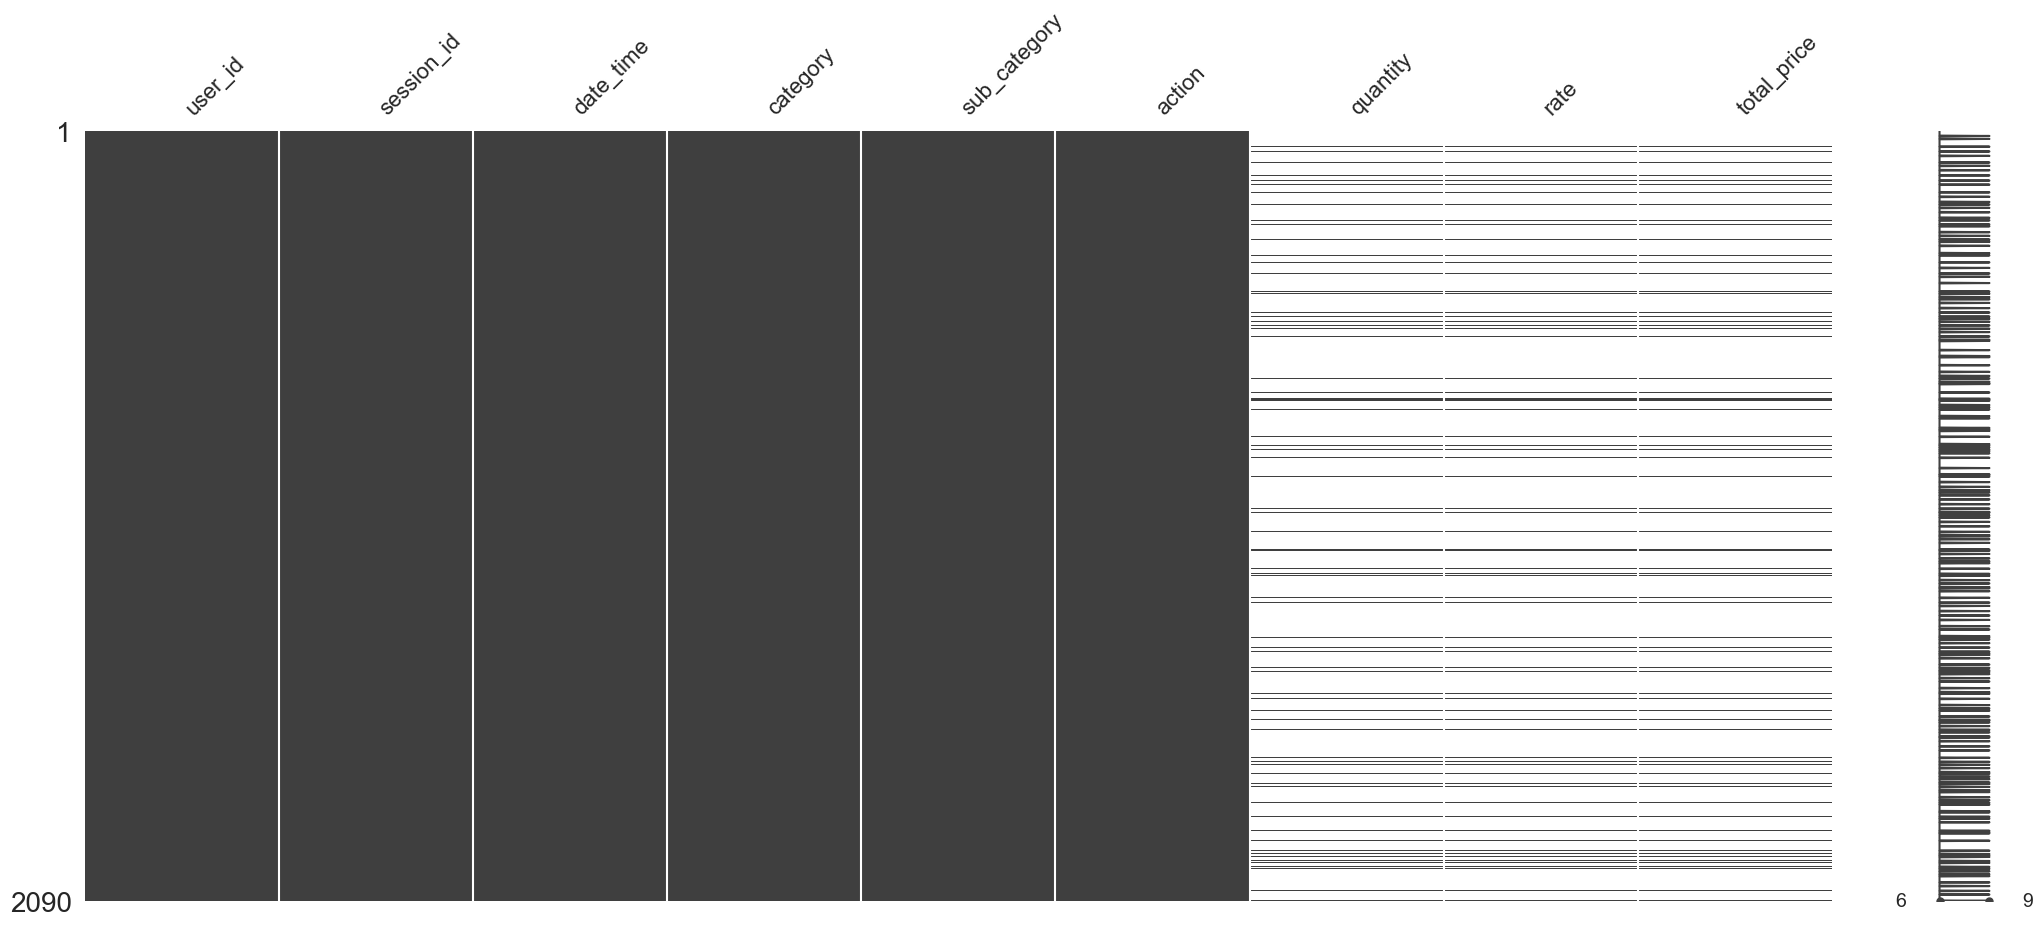

In [15]:
# Visualizing the missing values
msno.matrix(df1)

The white stripes show missing values. The white stripes are equivalent to the row related to the column where the missing value is. 

The missing values are present on the numerical features: quantity, rate and total price. Probably this happens because of no purchase, then the system launchs the information as a missing value.

## 1.5. Removing NA 

As we know, the columns quantity, rate and total price only have informations when the user purchases at least one product. Since these columns have around 90% of NA values, we cannot simply remove those rows. Thus, we are going to assume a value equals zero instead of NA value for this situation.

In [16]:
# quantity
df1['quantity'] = df1['quantity'].fillna(0)

# rate
df1['rate'] = df1['rate'].fillna(0)

# total_price
df1['total_price'] = df1['total_price'].fillna(0)

In [17]:
df1.isna().sum()

user_id         0
session_id      0
date_time       0
category        0
sub_category    0
action          0
quantity        0
rate            0
total_price     0
dtype: int64

## 1.6. Check Balanced Data

## 1.7. Descriptive Statistics

This section is to find inconsistencies, anomalies and also the main characteristics of our data.

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       2090 non-null   int64         
 1   session_id    2090 non-null   object        
 2   date_time     2090 non-null   datetime64[ns]
 3   category      2090 non-null   object        
 4   sub_category  2090 non-null   object        
 5   action        2090 non-null   object        
 6   quantity      2090 non-null   float64       
 7   rate          2090 non-null   float64       
 8   total_price   2090 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 147.1+ KB


In [19]:
df1.describe()

,user_id,quantity,rate,total_price
count,2.090000e+03,2090.000000,2090.000000,2090.000000
mean,5.383871e+10,0.285167,686.023923,909.344498
std,2.781474e+09,2.382323,5033.290983,6287.728594
min,5.144382e+10,0.000000,0.000000,0.000000
25%,5.176871e+10,0.000000,0.000000,0.000000
50%,5.220572e+10,0.000000,0.000000,0.000000
75%,5.566042e+10,0.000000,0.000000,0.000000
max,6.030264e+10,100.000000,90000.000000,160000.000000


In [20]:
num_attributes = df1.drop(columns="user_id").select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.drop(columns="session_id").select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes 

In [21]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,0.0,100.0,100.0,0.285167,0.0,2.381753,35.517850,1471.724892
1,rate,0.0,90000.0,90000.0,686.023923,0.0,5032.086703,11.406039,153.948294
2,total_price,0.0,160000.0,160000.0,909.344498,0.0,6286.224173,13.453022,251.941719


In [22]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1[df1["quantity"] > 0].drop(columns="user_id").describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,201.00,2.97,7.16,1.00,1.00,2.00,3.00,100.00
rate,201.00,7133.28,14778.15,10.00,500.00,1200.00,6000.00,90000.00
total_price,201.00,9455.37,18213.70,150.00,1000.00,2500.00,8000.00,160000.00


We will use the 75% (75 percentile) as the maximum threshold to avoid outliers.

In [23]:
df1[df1["quantity"] == 100]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1484,57767840151,dfxdf936-c74d-4002-a076,2019-10-09 21:53:00,Stationary,Pens,purchase,100.00,10.00,1000.00


In [24]:
df1[df1["rate"] == 90000]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1107,53652969521,bb343f67-81be-4b84-9cdb,2019-06-11 15:02:00,Laptop and Desktop,Gaming laptop,purchase,1.00,90000.00,90000.00


In [25]:
df1[df1["total_price"] == 160000]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1669,52787855576,fce8cdd0-4572-44df-8e74,2019-11-10 15:07:00,Tablets,iPad,purchase,2.00,80000.00,160000.00


- Standard deviation is too high compared to the mean values. 
- As we have positive values for skew, we have a skewness to the left. Probably due smaller quantities of products purchased and, consequently, smaller values for rate and total price.
- Since quantity has a 1471 value for kurtosis, it has a high peak.
- The maximum values occurred just one time for the three numerical features. Therefore, we may assume they are outliers.

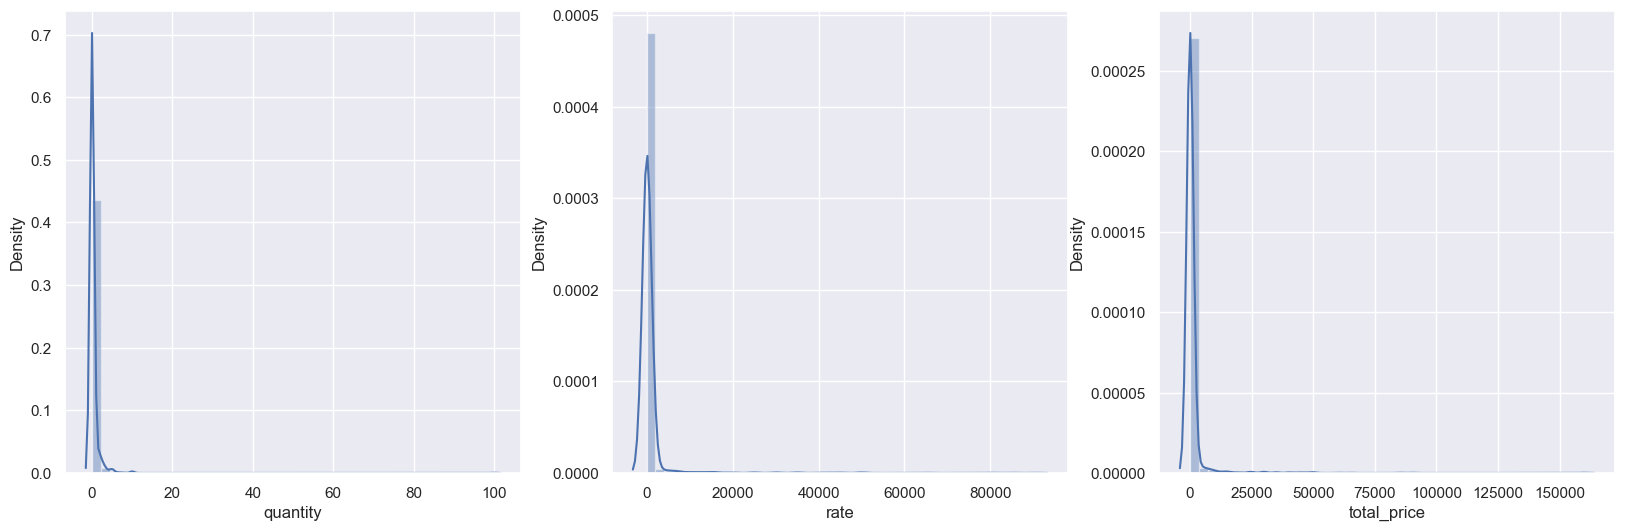

In [26]:
plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(df1["quantity"])

plt.subplot(132)
sns.distplot(df1["rate"])

plt.subplot(133)
sns.distplot(df1["total_price"])

plt.subplots_adjust(wspace = 0.2)

Let's see how the distribution is without the value zero.

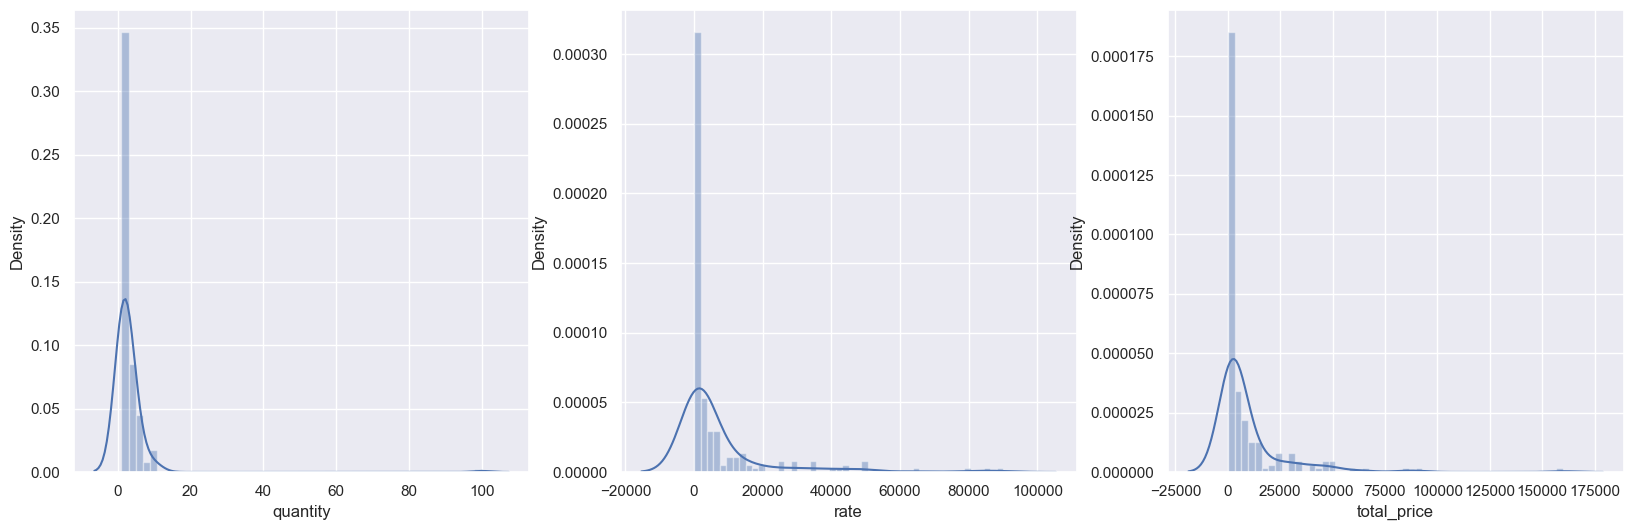

In [27]:
aux = df1[df1["quantity"] != 0]

plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(aux["quantity"])
#plt.xlim(0,)

plt.subplot(132)
sns.distplot(aux["rate"])
#plt.xlim(0,)

plt.subplot(133)
sns.distplot(aux["total_price"])
#plt.xlim(0,)

plt.subplots_adjust(wspace = 0.2)

The majority of purchases is around smaller values for quantity. The result is smaller values for rate and total price too. Let's try to filter the columns again.

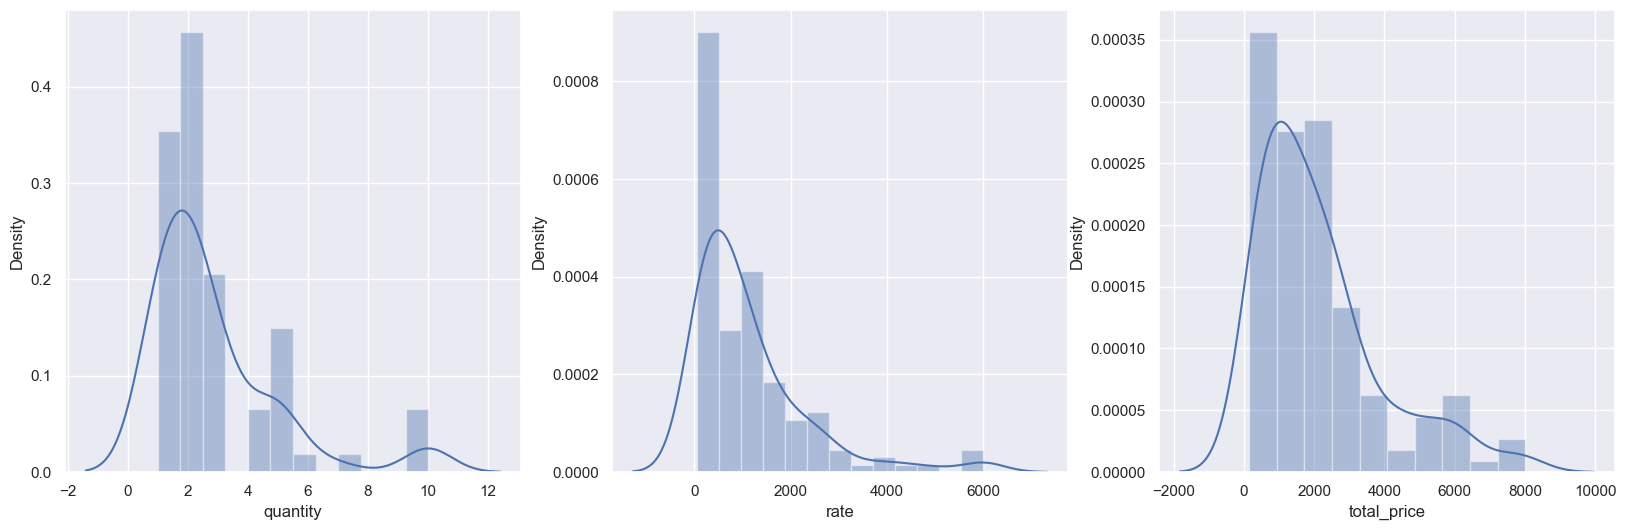

In [28]:
aux = df1[(df1["quantity"] != 0) & (df1["quantity"] < 100) & (df1["rate"] <= 6000) 
          & (df1["total_price"] <= 8000)]

plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(aux["quantity"])
#plt.xlim(0,)

plt.subplot(132)
sns.distplot(aux["rate"])
#plt.xlim(0,)

plt.subplot(133)
sns.distplot(aux["total_price"])
#plt.xlim(0,)

plt.subplots_adjust(wspace = 0.2)

- Now we see a left skew for the three features (positive skewness).
- We see a high kurtosis for quantity.
- We will keep this filter conditions in order to filter outliers rows in the next steps.

### 1.7.2. Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

category        105
sub_category    364
action           13
dtype: int64

In [30]:
cat_attributes.apply(lambda x: x.unique())

category        [Electronic Appliances, Men's Fashion, Mobile ...
sub_category    [Speakers, Jeans, Mobile, Cleaning sprays, Cha...
action          [first_app_open, search, product_view, read_re...
dtype: object

In [31]:
cat_attributes["category"].unique()

array(['Electronic Appliances', "Men's Fashion", 'Mobile & Accessories',
       'Cleaning supplies', 'Digital Devices', 'Accessories',
       'Stationary', 'Digital Content', 'Fitness', "Women's Fashion",
       'Household Supplies', 'Smart Wearables', 'Appliances', 'Pet Care',
       'Gardern and Outdoor', 'Camera Accessories', 'eCommerce',
       'Baby Care', 'Gaming Accessories', 'Musical Instruments',
       'Kitchen Appliances', 'Home Appliances', 'Entertainment Systems',
       'Software', 'Pendrives', 'Home Decor', 'Digital Appliances',
       'Electrical tools', 'Large appliances', 'Furnitures',
       'Religious items', 'Artwork', 'Baby Products', 'Car Accessories',
       "Kid's fashion", 'Motorbike Accessories', 'Toys', 'Music',
       'Music\n', 'Gifts', 'Tv and Appliances', 'Bags and Luggage',
       'Large Appliances', 'Industrial', 'Gardening', 'Grocery',
       'Winter Wear', 'Personal Care', "Men's Bottom Wear",
       "Men's Top Wear", 'Shoe care', 'Computer Periphera

In [32]:
cat_attributes["sub_category"].unique()

array(['Speakers', 'Jeans', 'Mobile', 'Cleaning sprays', 'Charging wire',
       'Kindle eBook', 'Watches', 'Cases', 'Books', 'Headphones',
       'Mouse pad', 'Fire Tv', 'Dumbells', 'Ethnic wear', 'Tws earbuds',
       'Cases and Covers', 'Shirts', 'Gloves', 'Dishwasher', 'Bumpers',
       'Denim jeans', 'Smart watches', 'Makeup kit', 'Ropes', 'Printers',
       'Shoes', 'Refrigerators', 'Harddisk', 'Cat food', 'Footwears',
       'Skipping Rope', 'Flower pot', 'Lens', 'Fire TV', 'Oil can',
       'Suspenders', 'Bow tie', 'Paints', 'Ear rings', 'Belt',
       'Frying pan', 'Rice cooker', 'CD-Driver', 'Bangles', 'Powerbells',
       'T-shirt', 'Container', 'Weigh scale', 'Tablet holder', 'Ring',
       'Tops', 'Charger', 'wrist band', 'Delivery bags', 'Women Jacket',
       'Water hose pipe', 'Coolers', 'Baby lotion', 'Aux Cable',
       'USB Cord', 'fitband', 'Screen Guard', 'laptop', 'Web camera',
       'Joystick', 'Tripods', 'Flute', 'Lamp', 'Surround system',
       'Pen stand', '

In [33]:
cat_attributes["action"].unique()

array(['first_app_open', 'search', 'product_view', 'read_reviews',
       'add_review', 'add_to_cart', 'checkout', 'purchase',
       'add_to_wishlist', 'click_wishlist_page', 'product_review',
       'add_to_wishist', 'read_review'], dtype=object)

In [34]:
cat_attributes.describe().T

,count,unique,top,freq
category,2090,105,Mobile & Accessories,139
sub_category,2090,364,Books,46
action,2090,13,read_reviews,342


### 1.7.3. Data Cleaning for Categorical Attributes

We must perform a categorical cleaning, since we have uppercase and words separated by spaces, and special char for the columns category and sub_category.

In [35]:
# category
df1['category'] = df1['category'].apply(lambda x: x.replace(' ', '_').\
                                        replace('\n', '').replace("'s", '').replace("&", "and").lower())

# sub_category
df1['sub_category'] = df1['sub_category'].apply(lambda x: x.replace(' ', '_').\
                                                replace("'s", '').replace("-", '_').lower())     

df1['action'] = df1['action'].apply(lambda x: 'read_reviews' if x in ('read_review') else x)
df1['action'] = df1['action'].apply(lambda x: 'add_to_wishlist' if x in ('add_to_wishist') else x)

In [36]:
df1["category"].unique()

array(['electronic_appliances', 'men_fashion', 'mobile_and_accessories',
       'cleaning_supplies', 'digital_devices', 'accessories',
       'stationary', 'digital_content', 'fitness', 'women_fashion',
       'household_supplies', 'smart_wearables', 'appliances', 'pet_care',
       'gardern_and_outdoor', 'camera_accessories', 'ecommerce',
       'baby_care', 'gaming_accessories', 'musical_instruments',
       'kitchen_appliances', 'home_appliances', 'entertainment_systems',
       'software', 'pendrives', 'home_decor', 'digital_appliances',
       'electrical_tools', 'large_appliances', 'furnitures',
       'religious_items', 'artwork', 'baby_products', 'car_accessories',
       'kid_fashion', 'motorbike_accessories', 'toys', 'music', 'gifts',
       'tv_and_appliances', 'bags_and_luggage', 'industrial', 'gardening',
       'grocery', 'winter_wear', 'personal_care', 'men_bottom_wear',
       'men_top_wear', 'shoe_care', 'computer_peripherals', 'health',
       'laptop_accessories', 'l

In [37]:
df1["sub_category"].unique()

array(['speakers', 'jeans', 'mobile', 'cleaning_sprays', 'charging_wire',
       'kindle_ebook', 'watches', 'cases', 'books', 'headphones',
       'mouse_pad', 'fire_tv', 'dumbells', 'ethnic_wear', 'tws_earbuds',
       'cases_and_covers', 'shirts', 'gloves', 'dishwasher', 'bumpers',
       'denim_jeans', 'smart_watches', 'makeup_kit', 'ropes', 'printers',
       'shoes', 'refrigerators', 'harddisk', 'cat_food', 'footwears',
       'skipping_rope', 'flower_pot', 'lens', 'oil_can', 'suspenders',
       'bow_tie', 'paints', 'ear_rings', 'belt', 'frying_pan',
       'rice_cooker', 'cd_driver', 'bangles', 'powerbells', 't_shirt',
       'container', 'weigh_scale', 'tablet_holder', 'ring', 'tops',
       'charger', 'wrist_band', 'delivery_bags', 'women_jacket',
       'water_hose_pipe', 'coolers', 'baby_lotion', 'aux_cable',
       'usb_cord', 'fitband', 'screen_guard', 'laptop', 'web_camera',
       'joystick', 'tripods', 'flute', 'lamp', 'surround_system',
       'pen_stand', 'mcafee_prot

In [38]:
df1["action"].unique()

array(['first_app_open', 'search', 'product_view', 'read_reviews',
       'add_review', 'add_to_cart', 'checkout', 'purchase',
       'add_to_wishlist', 'click_wishlist_page', 'product_review'],
      dtype=object)

### 1.7.4. Correlation Matrix

Cramer's V method to evaluate correlation between categorical attributes.

In [39]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

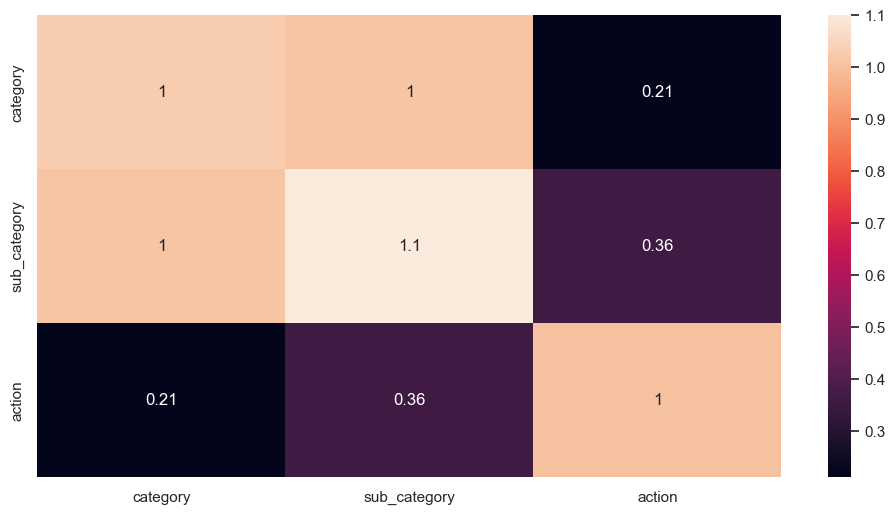

In [40]:
plt.figure(figsize =(12,6))

d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

- The maximum correlation value should be 1. Yet, sub_category is 1.1 correlated with sub_category. Since this happened for the same column, we are just going to consider this value as 1.
- category and sub_category are high correlated. Since we have much more unique values for sub_category (section 1.7.2), we are going to remove category column in the section 3.

# 2. Feature Engineering

In [41]:
df2 = df1.copy()

In [42]:
df2.dtypes

user_id                  int64
session_id              object
date_time       datetime64[ns]
category                object
sub_category            object
action                  object
quantity               float64
rate                   float64
total_price            float64
dtype: object

In [43]:
df2.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,men_fashion,jeans,product_view,0.00,0.00,0.00
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,men_fashion,jeans,read_reviews,0.00,0.00,0.00


## 2.1. Date Features

In [44]:
# year 
df2['year'] = df2['date_time'].dt.year

# month  
df2['month'] = df2['date_time'].dt.month

# day  
df2['day'] = df2['date_time'].dt.day

# day of week  
df2['day_of_week'] = df2['date_time'].dt.dayofweek

# week of year  
df2['week_of_year'] = df2['date_time'].dt.weekofyear

In [45]:
df2.shape

(2090, 14)

## 2.2. User Activity Features

#### Number of days active

In [46]:
# Calculating number of days active
temp_days_active = df2.groupby('user_id').agg({'date_time': 'nunique'}).reset_index()
temp_days_active.rename(columns={'date_time':'number_of_days_active'}, inplace=True)
print(temp_days_active.shape)
temp_days_active.head(3)

(401, 2)


,user_id,number_of_days_active
0,51443820326,3
1,51448162784,12
2,51455512201,10


In [47]:
# Adding days_active
df2 = pd.merge(df2, temp_days_active, on='user_id', how='left')
print(df2.shape)
df2.head(3)

(2090, 15)


,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3


#### Average days between purchase

In [48]:
temp = df2.copy()

temp_user_purchase_date = (temp[temp['action']=='purchase'].sort_values(by='date_time')
                           .groupby('user_id').agg({'date_time': lambda x: list(x)}).reset_index())
temp_user_purchase_date.head()

,user_id,date_time
0,51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]"
1,51455512201,[2019-10-19 19:12:00]
2,51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]"
3,51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]"
4,51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]"


In [49]:
# Calculating the maximum number of purchase days for each user
x = 0
for i in range(len(temp_user_purchase_date)):
    
    if x < len(temp_user_purchase_date.loc[i, "date_time"]):
        x = len(temp_user_purchase_date.loc[i, "date_time"])
        
    else:
        x = x
        
# Maximum number of purchases days
x

3

In [50]:
# Calculating the difference difference in days between purchases
def purch_time_diff(x):
    if len(x) == 2:
        return (x[1]-x[0]).days

    if len(x) == 3:
        diff_12 = (x[1]-x[0]).days
        diff_23 = (x[2]-x[1]).days
        return (diff_12+diff_23)/2

In [51]:
# Selecting purchase date
temp_user_purchase_date['purchase1'] = temp_user_purchase_date['date_time'].apply(lambda x: x[0])
temp_user_purchase_date['purchase2'] = temp_user_purchase_date['date_time'].apply(lambda x: x[1] if len(x)>1 else 0)
temp_user_purchase_date['purchase3'] = temp_user_purchase_date['date_time'].apply(lambda x: x[2] if len(x)>2 else 0)

temp_user_purchase_date['avg_days_between_purchase'] = temp_user_purchase_date['date_time']\
                                                       .apply(purch_time_diff)\
                                                       .fillna(0)

print(temp_user_purchase_date.shape)
temp_user_purchase_date.head()

(167, 6)


,user_id,date_time,purchase1,purchase2,purchase3,avg_days_between_purchase
0,51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]",2019-06-11 13:23:00,2019-12-12 19:22:00,0,184.00
1,51455512201,[2019-10-19 19:12:00],2019-10-19 19:12:00,0,0,0.00
2,51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]",2019-10-20 17:30:00,2019-12-15 19:03:00,0,56.00
3,51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]",2019-10-14 21:44:00,2019-11-12 21:27:00,0,28.00
4,51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]",2019-12-05 19:30:00,2019-12-12 21:15:00,0,7.00


"gc.collect()" is a function in Python that runs the garbage collector. The garbage collector is responsible for automatically freeing up memory that is no longer being used by the program. By calling "gc.collect()", you can manually force the garbage collector to run, which can be useful in certain situations where you want to free up memory as soon as possible.

In [52]:
gc.collect()

28137

In [53]:
# Adding average time between purchase
df2 = pd.merge(df2, temp_user_purchase_date[['user_id','avg_days_between_purchase']], 
                   on='user_id', how='left')
df2["avg_days_between_purchase"] = df2["avg_days_between_purchase"].fillna(0)
print(df2.shape)
df2.head(3)

(2090, 16)


,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,0.00


#### Purchase and Cart ratio

In [54]:
temp = df2.copy()

In [55]:
def purchase_ratios(action_col='add_to_cart',id_col='user_id', col_name='number_of_carts'):
    
    # Number of add_to_cart for each user
    test1 = (temp[temp['action']==action_col]
                          .groupby(id_col).agg({'session_id':'count'}).reset_index())
    test1.rename(columns={'session_id': col_name}, inplace=True)
    
    # Number of purchases for each user
    test2 = temp[temp['action']=='purchase'].groupby(id_col).agg({'session_id':'count'}).reset_index()
    test2.rename(columns={'session_id':'number_of_purchases'}, inplace=True)
    
    test_ratio = pd.merge(test1,test2,on=id_col, how='left')
    test_ratio = test_ratio.fillna(0)
    test_ratio[col_name+'_to_purchase_ratio'] = (test_ratio['number_of_purchases']/test_ratio[col_name])
    
    return test_ratio


In [56]:
# purchase and cart ratio
temp_cart_purch_ratio_user = purchase_ratios(action_col='add_to_cart',id_col='user_id',col_name='number_of_carts')

display(temp_cart_purch_ratio_user.head())
temp_cart_purch_ratio_user.describe()

,user_id,number_of_carts,number_of_purchases,number_of_carts_to_purchase_ratio
0,51448162784,2,2.00,1.00
1,51455512201,1,1.00,1.00
2,51462598385,2,2.00,1.00
3,51463622150,2,2.00,1.00
4,51465529647,3,2.00,0.67


,user_id,number_of_carts,number_of_purchases,number_of_carts_to_purchase_ratio
count,240.00,240.00,240.00,240.00
mean,53965915865.43,1.17,0.75,0.61
std,2767010340.70,0.41,0.70,0.53
min,51448162784.00,1.00,0.00,0.00
25%,51857206650.00,1.00,0.00,0.00
50%,52318501056.50,1.00,1.00,1.00
75%,55867444260.00,1.00,1.00,1.00
max,60302643179.00,3.00,3.00,3.00


In [57]:
gc.collect()

0

In [58]:
# Adding carts to purchase ratio
df2 = pd.merge(df2, temp_cart_purch_ratio_user[['user_id','number_of_carts_to_purchase_ratio']], 
                   on='user_id', how='left')
df2["number_of_carts_to_purchase_ratio"] = df2["number_of_carts_to_purchase_ratio"].fillna(0)
df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,0.00,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,0.00,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,0.00,0.00


#### Purchase and Whishlist ratio

In [59]:
temp = df2.copy()

In [60]:
# Click wishlist to purchase ratio
temp_click_wishlist_purch_ratio_user = purchase_ratios(action_col='click_wishlist_page',
                                             id_col='user_id', col_name='number_of_click_wishlist')

display(temp_click_wishlist_purch_ratio_user.head())
temp_click_wishlist_purch_ratio_user.describe()

,user_id,number_of_click_wishlist,number_of_purchases,number_of_click_wishlist_to_purchase_ratio
0,51448162784,1,2.00,2.00
1,51463622150,1,2.00,2.00
2,51465529647,1,2.00,2.00
3,51468519074,1,1.00,1.00
4,51475146821,1,0.00,0.00


,user_id,number_of_click_wishlist,number_of_purchases,number_of_click_wishlist_to_purchase_ratio
count,191.00,191.00,191.00,191.00
mean,54038646719.57,1.06,0.49,0.46
std,2800753089.25,0.27,0.69,0.64
min,51448162784.00,1.00,0.00,0.00
25%,51820710836.00,1.00,0.00,0.00
50%,52304977219.00,1.00,0.00,0.00
75%,56185191425.00,1.00,1.00,1.00
max,60302643179.00,3.00,3.00,2.00


In [61]:
# Add wishlist to purchase ratio
temp_add_wishlist_purch_ratio_user = purchase_ratios(action_col='add_to_wishlist',
                                             id_col='user_id',col_name='number_of_add_wishlist')

display(temp_add_wishlist_purch_ratio_user.head())
temp_add_wishlist_purch_ratio_user.describe()

,user_id,number_of_add_wishlist,number_of_purchases,number_of_add_wishlist_to_purchase_ratio
0,51463622150,1,2.00,2.00
1,51477448981,2,1.00,0.50
2,51517997197,2,2.00,1.00
3,51526464449,1,2.00,2.00
4,51565158157,4,3.00,0.75


,user_id,number_of_add_wishlist,number_of_purchases,number_of_add_wishlist_to_purchase_ratio
count,26.00,26.00,26.00,26.00
mean,52954574984.19,1.46,1.54,1.21
std,2529051760.69,0.76,0.71,0.69
min,51463622150.00,1.00,0.00,0.00
25%,51616418156.50,1.00,1.00,0.81
50%,51755725866.50,1.00,2.00,1.00
75%,52300513881.50,2.00,2.00,2.00
max,59533420690.00,4.00,3.00,2.00


In [62]:
gc.collect()

0

In [63]:
# Adding wishlist to purchase ratios (click & add)
df2 = pd.merge(df2, 
                   temp_click_wishlist_purch_ratio_user[['user_id','number_of_click_wishlist_to_purchase_ratio']], 
                   on='user_id', how='left')

df2 = pd.merge(df2, 
                   temp_add_wishlist_purch_ratio_user[['user_id','number_of_add_wishlist_to_purchase_ratio']], 
                   on='user_id', how='left')

df2["number_of_click_wishlist_to_purchase_ratio"] = df2["number_of_click_wishlist_to_purchase_ratio"].fillna(0)
df2["number_of_add_wishlist_to_purchase_ratio"] = df2["number_of_add_wishlist_to_purchase_ratio"].fillna(0)

df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,0.00,0.00,0.00,0.00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,0.00,0.00,0.00,0.00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,0.00,0.00,0.00,0.00


#### Path to Cart

In [64]:
temp = df2.copy()

In [65]:
# Filtering the dataset by max add_to_cart date for each user (All users who have done add_to_cart event)
temp = (temp.sort_values(by='date_time')
        [(temp.date_time <= temp.user_id.map(temp[temp['action']=='add_to_cart'].groupby('user_id').date_time.max()))
        ])
print(temp.shape)
print(temp.user_id.nunique())
temp.head(3)

(1192, 19)
240


,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio
942,51725305614,hfg03b-d558-4953-b218,2019-01-01 11:00:00,men_fashion,shirts,search,0.00,0.00,0.00,2019,1,1,1,1,23,118.00,1.00,1.00,1.00
943,51725305614,cbvg11b4-fadf-4d3c-8834,2019-01-01 11:05:00,men_fashion,shirts,product_view,0.00,0.00,0.00,2019,1,1,1,1,23,118.00,1.00,1.00,1.00
944,51725305614,gcv0ec1-a246-4d24-b94a,2019-01-01 11:10:00,men_fashion,shirts,read_reviews,0.00,0.00,0.00,2019,1,1,1,1,23,118.00,1.00,1.00,1.00


In [66]:
temp_path =  temp.sort_values(by='date_time').groupby('user_id').agg({'action': lambda x: list(x)}).reset_index()
temp_path.head()

,user_id,action
0,51448162784,"[first_app_open, search, product_view, read_re..."
1,51455512201,"[first_app_open, search, product_view, read_re..."
2,51462598385,"[search, product_view, read_reviews, add_to_ca..."
3,51463622150,"[first_app_open, search, read_reviews, search,..."
4,51465529647,"[search, add_to_cart, click_wishlist_page, add..."


The regular expression pattern "last_3_actions" matches strings that contain the words "add_to_cart" preceded by zero to three words separated by a single space.

The regular expression consists of two parts:

((?:\S+\s+){0,3}) matches zero to three sequences of one or more non-whitespace characters followed by a single space. This matches the preceding words, if any.

\badd_to_cart\b matches the word "add_to_cart". The word boundaries \b ensure that only complete words are matched and not just substrings.

The whole expression ((?:\S+\s+){0,3}\badd_to_cart) matches strings that contain the words "add_to_cart" preceded by zero to three words separated by a single space. The parentheses around the expression indicate that the matched text should be captured as a group and can be retrieved using the "re.findall()" function.

In [67]:
last_3_actions = r'((?:\S+\s+){0,3}\badd_to_cart)'

temp_path['action_cleaned'] = temp_path['action'].apply(lambda x: ' '.join(x))
temp_path['last_3_actions'] = temp_path['action_cleaned'].apply(lambda x: re.findall(last_3_actions, x))
temp_path.head()

,user_id,action,action_cleaned,last_3_actions
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,..."
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart]
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,..."
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...


In [68]:
# Cleaning and selecting the latest path for each user
temp_path['final_3_actions'] = temp_path['last_3_actions'].apply(lambda x: x[0] if len(x)==1 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[1] if len(x)==2 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[2] if len(x)==3 else x)

temp_path.head()

,user_id,action,action_cleaned,last_3_actions,final_3_actions
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,...",search read_reviews add_to_cart
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,...",search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...,search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...,search add_to_cart


In [69]:
# Cleaning and selecting the latest path for each user
temp_path['final_3_actions'] = temp_path['last_3_actions'].apply(lambda x: x[0] if len(x)==1 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[1] if len(x)==2 else x)
temp_path['final_3_actions'] = temp_path['final_3_actions'].apply(lambda x: x[2] if len(x)==3 else x)

temp_path.head()

,user_id,action,action_cleaned,last_3_actions,final_3_actions
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,...",search read_reviews add_to_cart
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,...",search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...,search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...,search add_to_cart


In [70]:
temp_path.final_3_actions.value_counts()

product_view read_reviews click_wishlist_page add_to_cart       29
add_to_cart                                                     25
read_reviews click_wishlist_page add_to_cart                    25
click_wishlist_page add_to_cart                                 24
search product_view read_reviews add_to_cart                    21
read_reviews add_to_cart                                        10
product_view read_reviews add_to_cart                           10
read_reviews product_view click_wishlist_page add_to_cart        9
search read_reviews click_wishlist_page add_to_cart              9
search product_view add_to_cart                                  6
search product_view click_wishlist_page add_to_cart              6
product_view click_wishlist_page add_to_cart                     6
search read_reviews add_to_cart                                  5
product_view add_to_cart                                         3
first_app_open search read_reviews add_to_cart                

In [71]:
# Grouping the paths to top 10 and rest as others
top_10_paths = temp_path.final_3_actions.value_counts()[:10].index.to_list()
print(top_10_paths)
temp_path['top_paths'] = temp_path['final_3_actions'].apply(lambda x: x if x in top_10_paths else 'others')
temp_path.head()

['product_view read_reviews click_wishlist_page add_to_cart', 'add_to_cart', 'read_reviews click_wishlist_page add_to_cart', 'click_wishlist_page add_to_cart', 'search product_view read_reviews add_to_cart', 'read_reviews add_to_cart', 'product_view read_reviews add_to_cart', 'read_reviews product_view click_wishlist_page add_to_cart', 'search read_reviews click_wishlist_page add_to_cart', 'search product_view add_to_cart']


,user_id,action,action_cleaned,last_3_actions,final_3_actions,top_paths
0,51448162784,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,"[search product_view read_reviews add_to_cart,...",search read_reviews add_to_cart,others
1,51455512201,"[first_app_open, search, product_view, read_re...",first_app_open search product_view read_review...,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart,search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_ca...",search product_view read_reviews add_to_cart s...,"[search product_view read_reviews add_to_cart,...",search product_view add_to_cart,search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search,...",first_app_open search read_reviews search prod...,[purchase search click_wishlist_page add_to_ca...,search product_view add_to_cart,search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add...",search add_to_cart click_wishlist_page add_to_...,[search add_to_cart click_wishlist_page add_to...,search add_to_cart,others


In [72]:
temp_path.top_paths.value_counts()

others                                                       72
product_view read_reviews click_wishlist_page add_to_cart    29
read_reviews click_wishlist_page add_to_cart                 25
add_to_cart                                                  25
click_wishlist_page add_to_cart                              24
search product_view read_reviews add_to_cart                 21
product_view read_reviews add_to_cart                        10
read_reviews add_to_cart                                     10
search read_reviews click_wishlist_page add_to_cart           9
read_reviews product_view click_wishlist_page add_to_cart     9
search product_view add_to_cart                               6
Name: top_paths, dtype: int64

In [73]:
gc.collect()

0

In [74]:
# Adding top path-to-cart
df2 = pd.merge(df2, temp_path[['user_id','top_paths']], 
                   on='user_id', how='left')

df2["top_paths"] = df2["top_paths"].fillna("Not added to cart")
df2.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_days_active,avg_days_between_purchase,number_of_carts_to_purchase_ratio,number_of_click_wishlist_to_purchase_ratio,number_of_add_wishlist_to_purchase_ratio,top_paths
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,2,0.00,0.00,0.00,0.00,Not added to cart
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,2,0.00,0.00,0.00,0.00,Not added to cart
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,3,0.00,0.00,0.00,0.00,Not added to cart


## 2.3. Category/Subcategory Features

# 3. Feature Filtering and Selection

We are going to filter rows and select columns based on the previous data description section. 

In [46]:
df3 = df2.copy()

## 3.1. Feature Filtering

Removing outliers based on 75 percentile. 

In [47]:
df3 = df3[(df3["quantity"] < 100) & (df3["rate"] <= 6000) 
          & (df3["total_price"] <= 8000)]

## 3.2. Columns Selection

Based on the section 1.7.4, we chose the category column to be removed. We must have the minimum number of columns which describe the same phenomenon in the model in order to avoid overfitting.

In [48]:
cols_drop = ["category"]
df3 = df3.drop(cols_drop, axis=1)

In [49]:
df2.shape

(2090, 14)

In [50]:
df3.shape

(2032, 13)

# 4. Exploratory Data Analysis (EDA)

The main objectives of this section is:

- To acquire business experience from data.
- To generate insights to the business team.
- To evaluate features impact over the phenomenon.

In [51]:
df4 = df2.copy()

In [52]:
df4.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,men_fashion,jeans,product_view,0.00,0.00,0.00,2019,1,10,3,2
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,men_fashion,jeans,read_reviews,0.00,0.00,0.00,2019,1,10,3,2


## 4.1. Univariate Analysis

In [53]:
profile = ProfileReport(df4, title='Customer Propensity to Purchase')
profile.to_file(output_file='customer_propensity_purchase_statistics_after_cleaning.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

We found that the columns quantity, rate and total_price are high correlation with each other. We are going to better analyze before deciding remove each of them.

In [54]:
# Timerange of data
print("Min Date: " +str(df4.date_time.min()))
print("Max Date: " +str(df4.date_time.max()))
print("Range: " +str(df4.date_time.max()-df4.date_time.min()))

Min Date: 2019-01-01 11:00:00
Max Date: 2019-12-22 17:52:00
Range: 355 days 06:52:00


In [55]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df4[df4["quantity"] > 0].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,201.00,53901272628.92,2816738504.08,51448162784.00,51725305614.00,52313781035.00,55538327311.00,60302643179.00
quantity,201.00,2.97,7.16,1.00,1.00,2.00,3.00,100.00
rate,201.00,7133.28,14778.15,10.00,500.00,1200.00,6000.00,90000.00
total_price,201.00,9455.37,18213.70,150.00,1000.00,2500.00,8000.00,160000.00
year,201.00,2019.00,0.00,2019.00,2019.00,2019.00,2019.00,2019.00
month,201.00,8.29,3.04,1.00,6.00,10.00,10.00,12.00
day,201.00,14.15,6.18,1.00,11.00,11.00,17.00,31.00
day_of_week,201.00,2.32,1.89,0.00,0.00,2.00,4.00,6.00
week_of_year,201.00,34.27,13.31,2.00,24.00,41.00,44.00,51.00


The three variables have the same count. We may not choose any variable based on a minor count though.

Total Unique Categories: 101


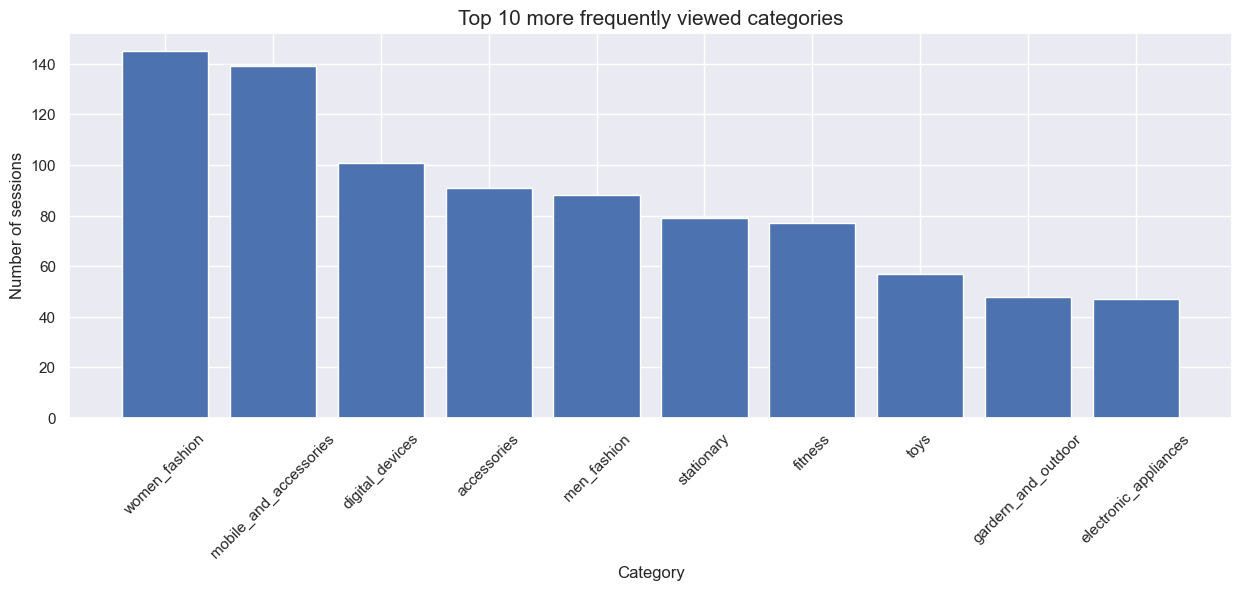

In [56]:
# Distribution of Category
print("Total Unique Categories: " + str(df4.category.nunique()))
temp_category = df4.groupby('category')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_category.category, temp_category.session_id)
plt.title("Top 10 more frequently viewed categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of sessions")
plt.show()

Total Unique SubCategories: 358


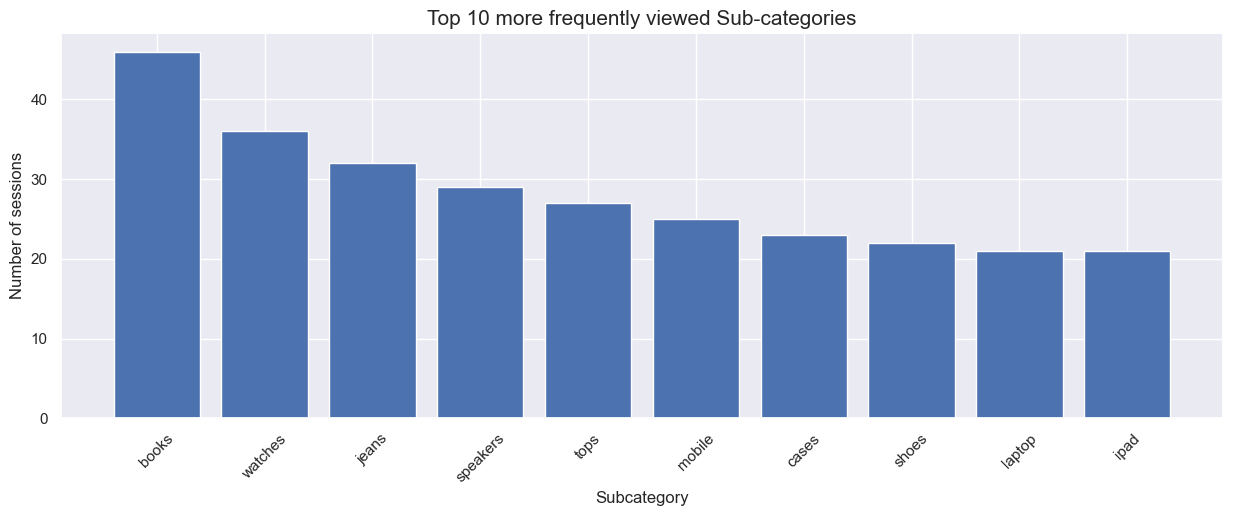

In [57]:
# Distribution of SubCategory
print("Total Unique SubCategories: " + str(df4.sub_category.nunique()))
temp_subcategory = df4.groupby('sub_category')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_subcategory.sub_category, temp_subcategory.session_id)
plt.title("Top 10 more frequently viewed Sub-categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Subcategory")
plt.ylabel("Number of sessions")
plt.show()

read_reviews           343
search                 320
product_view           292
add_to_cart            280
checkout               202
click_wishlist_page    202
purchase               201
first_app_open         121
add_review              69
add_to_wishlist         38
product_review          22
Name: action, dtype: int64

Total Unique Actions: 11


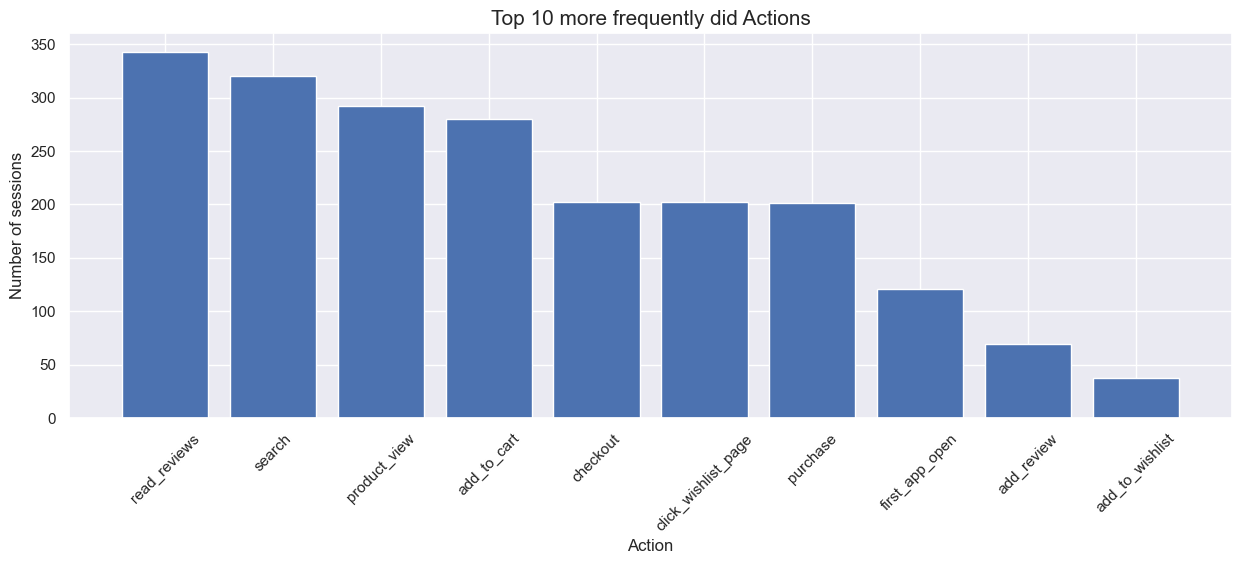

In [58]:
# Distribution of Action
display(df4.action.value_counts())

print("Total Unique Actions: " + str(df4.action.nunique()))
temp_actions = df4.groupby('action')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_actions.action, temp_actions.session_id)
plt.title("Top 10 more frequently did Actions", size=15)
plt.xticks(rotation=45)
plt.xlabel("Action")
plt.ylabel("Number of sessions")
plt.show()

## 4.2 Bivariate Analysis

We are going to perform bivariate analysis in order evaluate how the features are correlated with the target variable.

Based on the initial understanding of the different columns in the data (univariate analysis), we can create some hypothesis (if any) or try to ask more complex questions such as:

1. How many unique users in the data and how many of them purchased at least once? Also, what is the average number of purchase per customer?
2. Which is the most purchased Category/Sub-category?
3. Do people add the products to cart before they purchase or buy directly?
4. What is the average time taken by a user to buy a product?
5. What is the average time between repeat purchase?
6. What is the trend of unique users across the time period?
7. What is the trend of purchase across the time period?

This is not the exhaustive list but good to start with.

#### 1. How many unique users in the data and how many of them purchased at least once? Also, what is the average number of purchase per customer?

The "agg" function in Python: this is typically used to aggregate data in a DataFrame. Specifically, it is counting the number of rows in the "sub_category" column of the DataFrame. As we are filtering the sub_category "purchase", we see the number of rows for purchase. The result of this function would be a single value representing the count of rows in the "sub_category" column equals to "purchase". As we grouped by user_id before, thus the result is the number of purchase rows per user_id (an average value). 

In [59]:
# unique customers 
total_users = df4.user_id.nunique()
print(f"Total customers: {total_users}.")

# at least 1 purchase customer
atleast_one_purchase_cust = df4[df4['action']=='purchase']['user_id'].nunique()
conversion = 100*round(atleast_one_purchase_cust/total_users, 2)
print(f"Customers who made at least 1 purchase: {atleast_one_purchase_cust} ({conversion}% conversion)")

# avg purchase per customer
purch_dist_by_cust = (df4[df4['action']=='purchase'].groupby('user_id').agg({'sub_category': 'count'})
                      .reset_index().sort_values(by='sub_category', ascending=False) # True or False
                     )
purch_dist_by_cust.rename(columns={'sub_category':'number_of_purchase'}, inplace=True)

print(f"Average number of purchase per customer: {round(purch_dist_by_cust.number_of_purchase.mean(), 2)}")

print("\nDistribution of Number of Purchases:")
display(purch_dist_by_cust[['number_of_purchase']].describe())

Total customers: 401.
Customers who made at least 1 purchase: 167 (42.0% conversion)
Average number of purchase per customer: 1.2

Distribution of Number of Purchases:


,number_of_purchase
count,167.00
mean,1.20
std,0.43
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,3.00


#### 2. Which is the most purchased category and sub-category? 

We considered the number of distinct users who purchased in the categories, not the quantity.

Total Unique Categories: 101


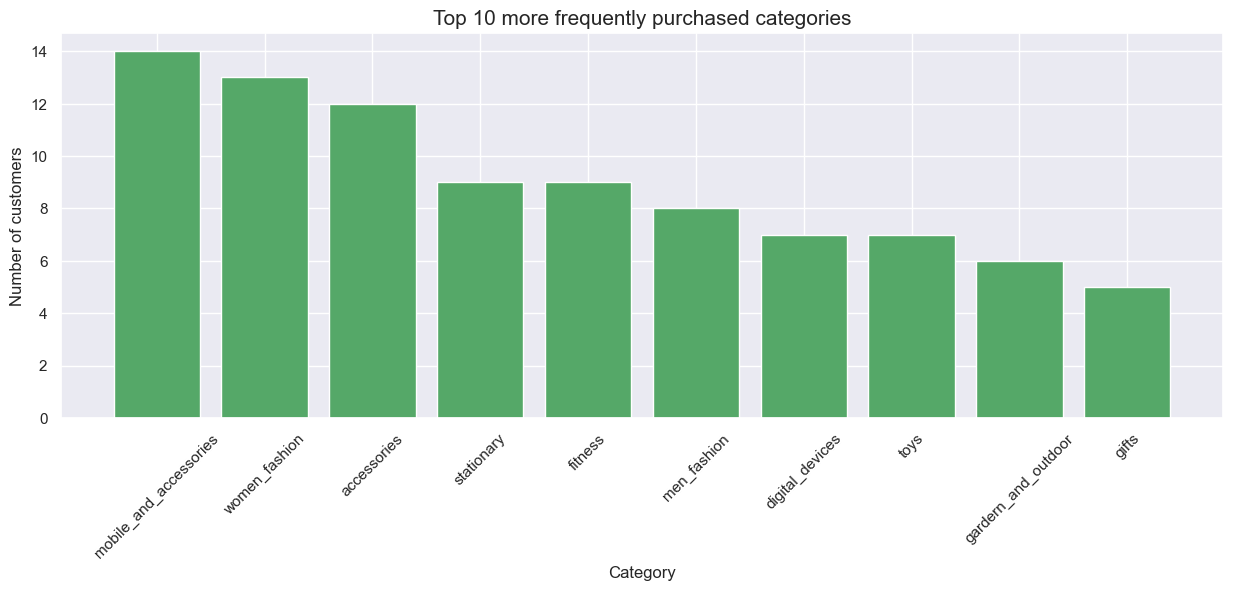

Total Unique Sub-categories: 358


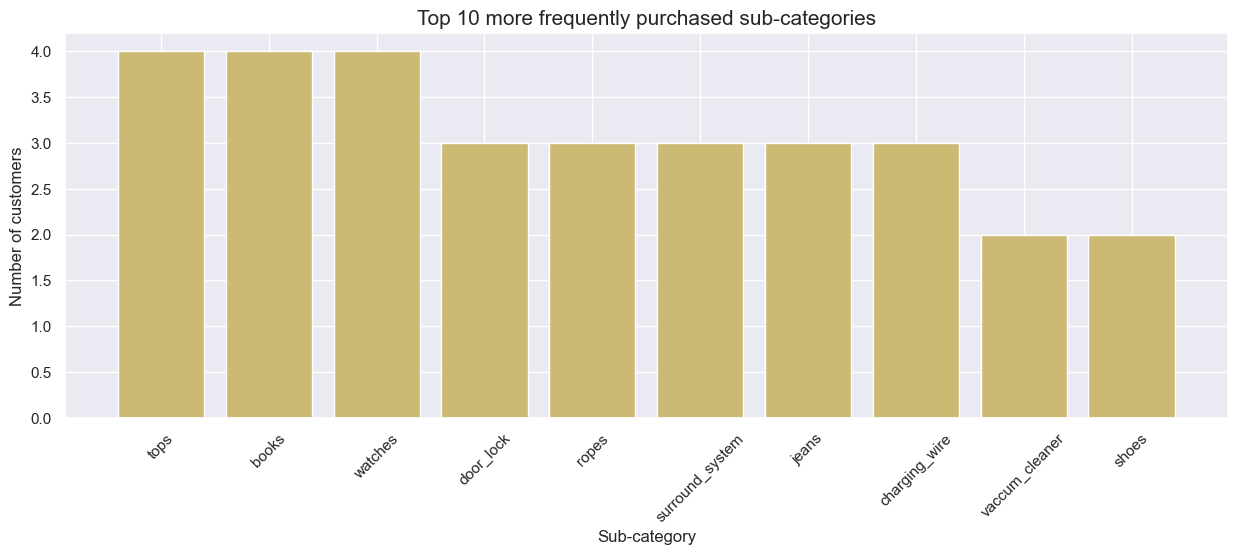

In [60]:
# Top 10 purchased categories
print("Total Unique Categories: {}".format(df4.category.nunique()))
temp_category = df4[df4['action']=='purchase'].groupby('category')['user_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15, 5))
plt.bar(temp_category.category, temp_category.user_id, color='g')
plt.title("Top 10 more frequently purchased categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of customers")
plt.show()

# Top 10 purchased SubCategory
print("Total Unique Sub-categories: {}".format(df4.sub_category.nunique()))
temp_subcategory = df4[df4['action']=='purchase'].groupby('sub_category')['user_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15, 5))
plt.bar(temp_subcategory.sub_category, temp_subcategory.user_id, color='y')
plt.title("Top 10 more frequently purchased sub-categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Sub-category")
plt.ylabel("Number of customers")
plt.show()

#### 3. Do people add the products to cart before they purchase or buy directly?

In [61]:
# direct purchase
purchase_users = df4[df4['action']=='purchase'].groupby('user_id')['action'].count().reset_index()

# add to cart
cart_users = df4[df4['action']=='add_to_cart'].groupby('user_id')['action'].count().reset_index()

# merge
temp_direct = pd.merge(purchase_users, cart_users, on='user_id', how='left', indicator=True)
temp_cart = pd.merge(cart_users, purchase_users, on='user_id', how='left', indicator=True)

In [62]:
temp_direct

,user_id,action_x,action_y,_merge
0,51448162784,2,2.00,both
1,51455512201,1,1.00,both
2,51462598385,2,2.00,both
3,51463622150,2,2.00,both
4,51465529647,2,3.00,both
...,...,...,...,...
162,60029406377,1,NaN,left_only
163,60034334067,1,1.00,both
164,60089394505,1,1.00,both
165,60238282834,3,3.00,both


In [63]:
temp_cart

,user_id,action_x,action_y,_merge
0,51448162784,2,2.00,both
1,51455512201,1,1.00,both
2,51462598385,2,2.00,both
3,51463622150,2,2.00,both
4,51465529647,3,2.00,both
...,...,...,...,...
235,60034334067,1,1.00,both
236,60089394505,1,1.00,both
237,60238282834,3,3.00,both
238,60300257008,1,NaN,left_only


In [64]:
direct_buy = temp_direct[temp_direct['_merge']=='left_only'].shape[0]
cart_only = temp_cart[temp_cart['_merge']=='left_only'].shape[0] # added to cart but not purchased

In [65]:
print("Total unique users who purchased: {}.".format(purchase_users.shape[0]))
print("Total direct buy (without adding to cart): {}.".format(direct_buy))
print("Total add_to_cart buy: {}.".format(cart_users.shape[0] - cart_only))

print("\nTotal unique users who added to cart: {}.".format(cart_users.shape[0]))
print("Total users who only added to cart (no purchase): {}.".format(cart_only))

Total unique users who purchased: 167.
Total direct buy (without adding to cart): 20.
Total add_to_cart buy: 147.

Total unique users who added to cart: 240.
Total users who only added to cart (no purchase): 93.


#### 4. What is the average and median time taken by a user to buy a product?

In [66]:
# purchases per distinct customer
purch_dist_by_cust

,user_id,number_of_purchase
165,60238282834,3
17,51565158157,3
0,51448162784,2
108,53966220604,2
34,51725305614,2
...,...,...
66,52114046370,1
65,52112239597,1
64,52094145973,1
63,52090547553,1


In [67]:
# Also after purchase users are either adding review or not. But since add_review event is low (69), ignoring it now
temp = df4.copy()
temp = pd.merge(temp, purch_dist_by_cust, on='user_id', how='left')
temp['number_of_purchase'] = temp['number_of_purchase'].fillna(0)

# max and min purchase datetime per user
temp['min_time'] = temp.groupby('user_id')['date_time'].transform(min) # initial time
temp['max_purchase_time'] = temp.groupby('user_id')['date_time'].transform(max) # purchase time

In [68]:
temp.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year,number_of_purchase,min_time,max_purchase_time
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2,0.00,2019-01-10 10:20:00,2019-01-10 10:22:00
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.00,0.00,0.00,2019,1,10,3,2,0.00,2019-01-10 10:20:00,2019-01-10 10:22:00
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.00,0.00,0.00,2019,1,10,3,2,0.00,2019-01-10 14:00:00,2019-01-10 14:12:00



Summary stats (Time diff in days):


,time_diff_days
count,2090.00
mean,58.56
std,94.37
min,0.00
25%,0.00
50%,0.00
75%,105.00
max,335.00


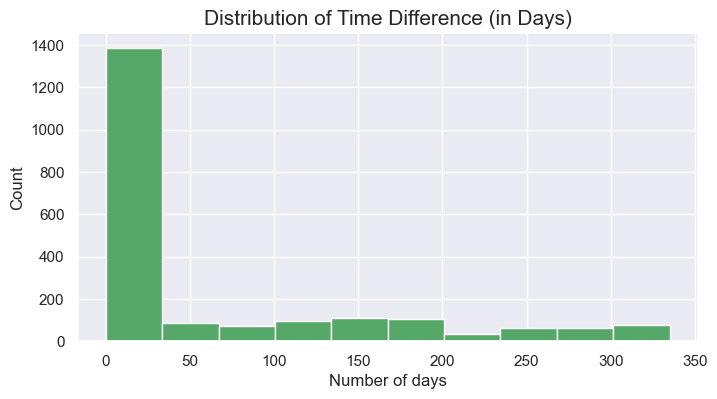

In [69]:
# Time difference between max and min datetime 
temp['time_diff_days'] = (temp['max_purchase_time'] - temp['min_time']).dt.days

print("\nSummary stats (Time diff in days):")
display(temp[['time_diff_days']].describe())

plt.figure(figsize=(8,4))
plt.hist(temp['time_diff_days'], density=False, color='g')
plt.title("Distribution of Time Difference (in Days)", size=15)
plt.xlabel("Number of days")
plt.ylabel("Count")
plt.show()


Summary stats (Time diff in minutes):


,time_diff_minutes
count,2090.00
mean,231.71
std,394.75
min,0.00
25%,14.00
50%,30.00
75%,242.00
max,1404.00


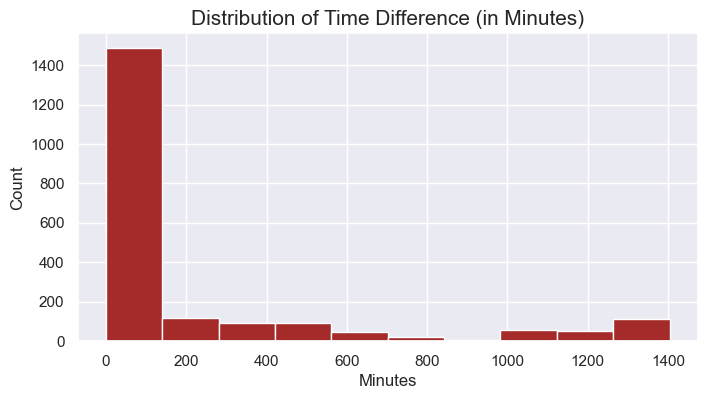

In [70]:
# Time difference between max and min datetime 
temp['time_diff_minutes'] = (temp['max_purchase_time'] - temp['min_time']).dt.seconds/60

print("\nSummary stats (Time diff in minutes):")
display(temp[['time_diff_minutes']].describe())

plt.figure(figsize=(8,4))
plt.hist(temp['time_diff_minutes'], density=False, color='brown')
plt.title("Distribution of Time Difference (in Minutes)", size=15)
plt.xlabel("Minutes")
plt.ylabel("Count")

plt.show()

To look at the median time is more realistic since average is biased for outliers.

- Average time to buy: 231 minutes.
- Median time to buy: 30 minutes.

#### 5. What is the average and median time between repeated purchases?

In [71]:
# Average time between repeat purchase
temp = df4.copy()
temp = pd.merge(temp, purch_dist_by_cust, on='user_id', how='left')
temp['number_of_purchase'] = temp['number_of_purchase'].fillna(0)
temp = temp[temp['number_of_purchase'] > 1].reset_index(drop=True)
print("Total users who made more than 1 purchase: {}.".format(temp.user_id.nunique()))

Total users who made more than 1 purchase: 32.


In [72]:
test = temp[temp['action']=='purchase'].sort_values(by=['user_id','date_time'])
test = test.groupby('user_id').agg({'date_time': lambda x: list(x)})

In [73]:
test

,date_time
user_id,
51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]"
51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]"
51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]"
51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]"
51480378215,"[2019-04-09 17:24:00, 2019-10-24 21:18:00]"
51481443687,"[2019-05-11 13:23:00, 2019-08-16 11:27:00]"
51517997197,"[2019-07-18 18:27:00, 2019-10-22 18:12:00]"
51526464449,"[2019-09-25 14:38:00, 2019-10-28 18:23:00]"
51565158157,"[2019-06-18 11:17:00, 2019-08-23 18:32:00, 201..."


In [74]:
def purch_time_diff(x):
    if len(x) == 2:
        return (x[1]-x[0]).days

    if len(x) == 3:
        diff_12 = (x[1]-x[0]).days
        diff_23 = (x[2]-x[1]).days
        return (diff_12 + diff_23)/2
    
test['diff'] = test['date_time'].apply(purch_time_diff)
test = test.reset_index()
test

,user_id,date_time,diff
0,51448162784,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]",184.00
1,51462598385,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]",56.00
2,51463622150,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]",28.00
3,51465529647,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]",7.00
4,51480378215,"[2019-04-09 17:24:00, 2019-10-24 21:18:00]",198.00
5,51481443687,"[2019-05-11 13:23:00, 2019-08-16 11:27:00]",96.00
6,51517997197,"[2019-07-18 18:27:00, 2019-10-22 18:12:00]",95.00
7,51526464449,"[2019-09-25 14:38:00, 2019-10-28 18:23:00]",33.00
8,51565158157,"[2019-06-18 11:17:00, 2019-08-23 18:32:00, 201...",57.00
9,51589427926,"[2019-04-03 11:17:00, 2019-10-23 20:23:00]",203.00



Summary stats (Time diff in days):


,diff
count,32.00
mean,101.03
std,76.82
min,0.00
25%,35.25
50%,90.50
75%,177.25
max,245.00


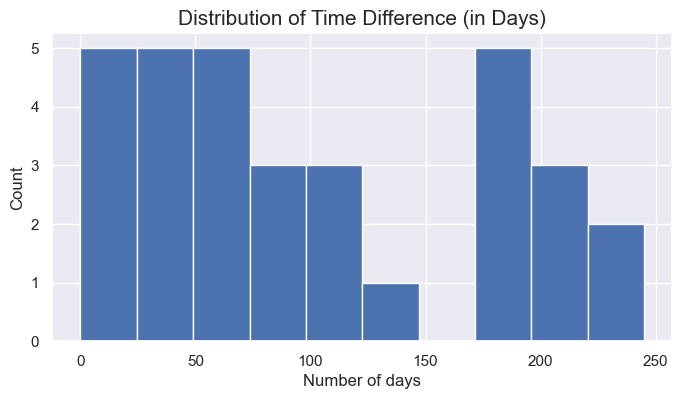

In [75]:
print("\nSummary stats (Time diff in days):")
display(test[['diff']].describe())

plt.figure(figsize=(8,4))
plt.hist(test['diff'], density=False, color='b')
plt.title("Distribution of Time Difference (in Days)",size=15)
plt.xlabel("Number of days")
plt.ylabel("Count")
plt.show()

- Average time: 101 days.
- Median time: 90 days.

#### 6. What is the trend of unique users across time period?

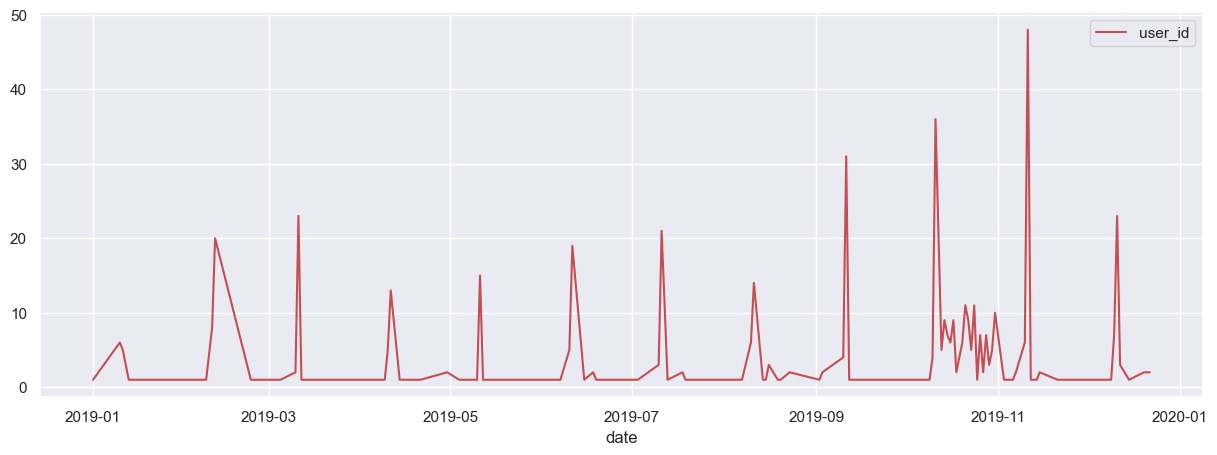

In [76]:
# Converting to date
temp = df4.copy()
temp['date'] = temp['date_time'].dt.date

# Number of unique customer per date
temp = temp.groupby('date').agg({'user_id': 'nunique'}).reset_index().sort_values(by='date')

# plot over time
temp.set_index('date').plot(figsize=(15,5), color='r')
plt.show()

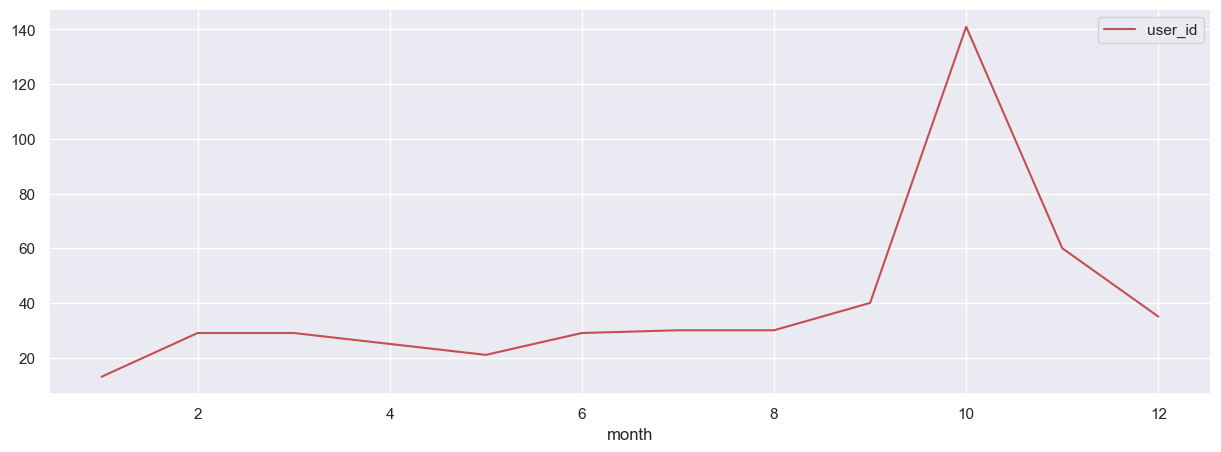

In [77]:
# Converting into month
temp = df4.copy()
temp['month'] = temp['date_time'].dt.month

# Number of unique users per month
temp = temp.groupby('month').agg({'user_id': 'nunique'}).reset_index().sort_values(by='month')

# plot over time
temp.set_index('month').plot(figsize=(15,5),color='r')
plt.show()

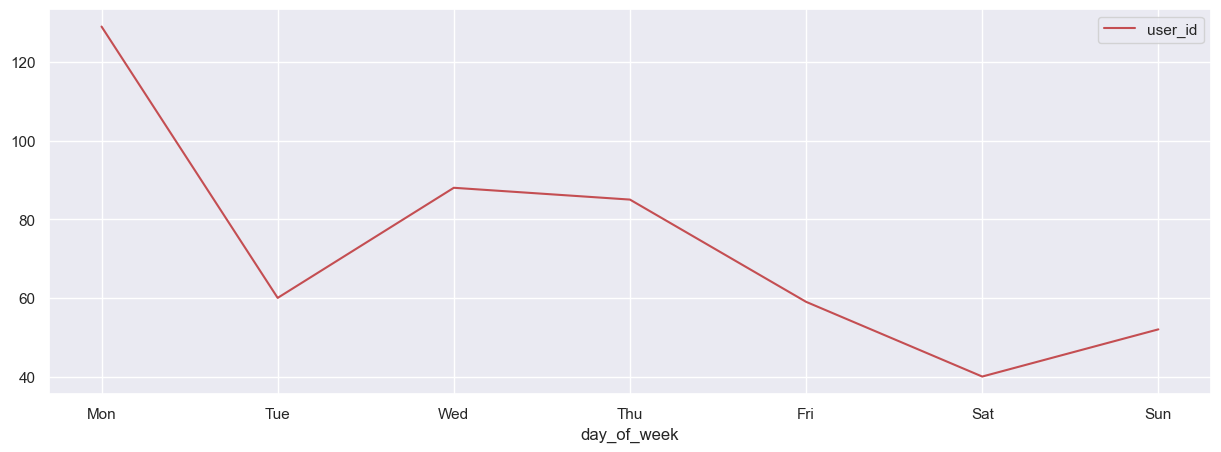

In [78]:
# Converting into day of week
temp = df4.copy()
temp['day_of_week'] = temp['date_time'].dt.dayofweek

# Number of unique users per day of week
temp = temp.groupby('day_of_week').agg({'user_id': 'nunique'}).reset_index().sort_values(by='day_of_week')

# plot over day of week
temp.set_index('day_of_week').plot(figsize=(15,5),color='r')
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

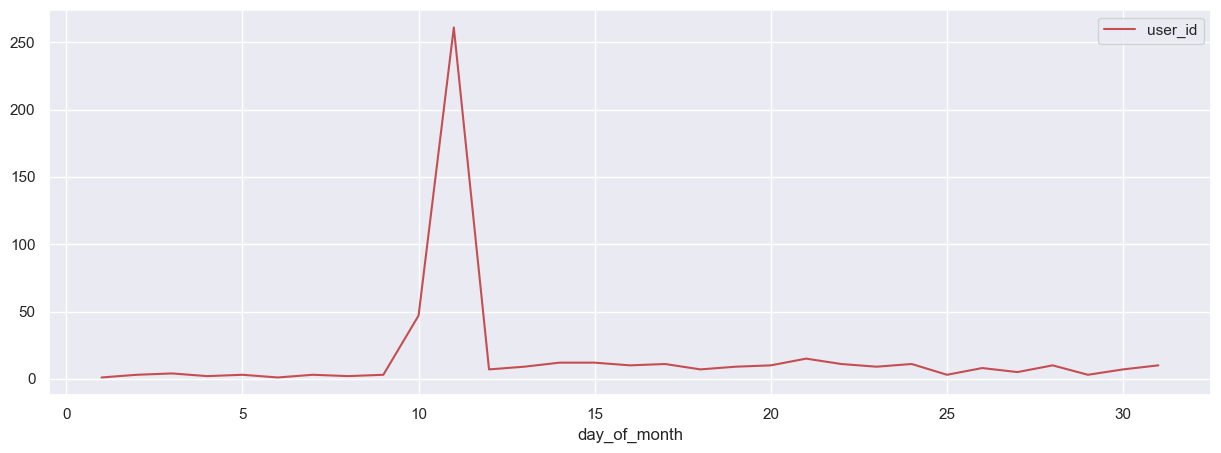

In [79]:
# Converting into day of month
temp = df4.copy()
temp['day_of_month'] = temp['date_time'].dt.day

# Number of unique users per day of month
temp = temp.groupby('day_of_month').agg({'user_id': 'nunique'}).reset_index().sort_values(by='day_of_month')

# Plot over day of month
temp.set_index('day_of_month').plot(figsize=(15,5),color='r')
plt.show()

#### 7. What is the trend of purchase across the time period?

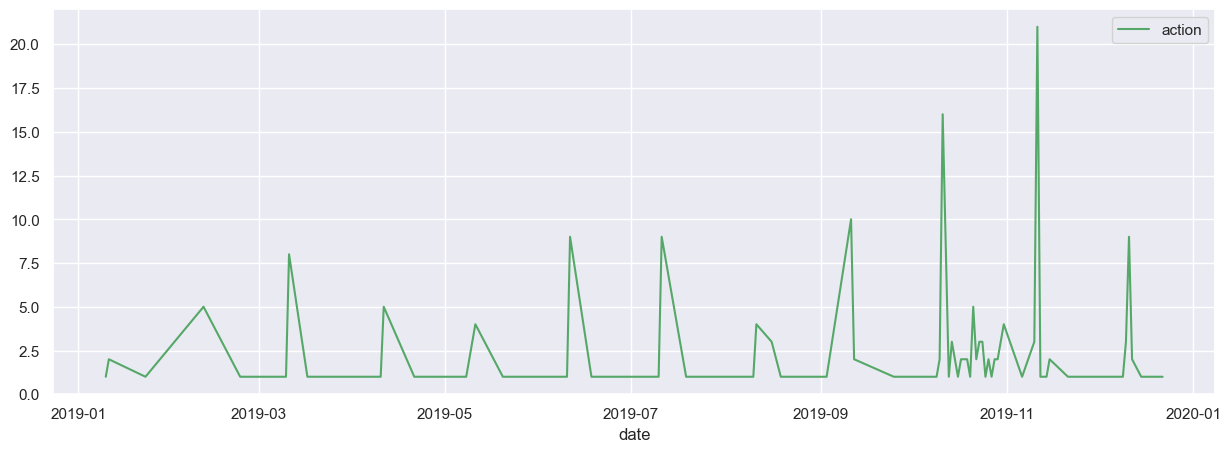

In [80]:
# Converting into date
temp = df4.copy()
temp['date'] = temp['date_time'].dt.date

# Number of unique users over the time
temp = temp[temp['action']=='purchase'].groupby('date').agg({'action': 'count'}).reset_index().sort_values(by='date')

# plot over the time
temp.set_index('date').plot(figsize=(15,5), color='g')
plt.show()

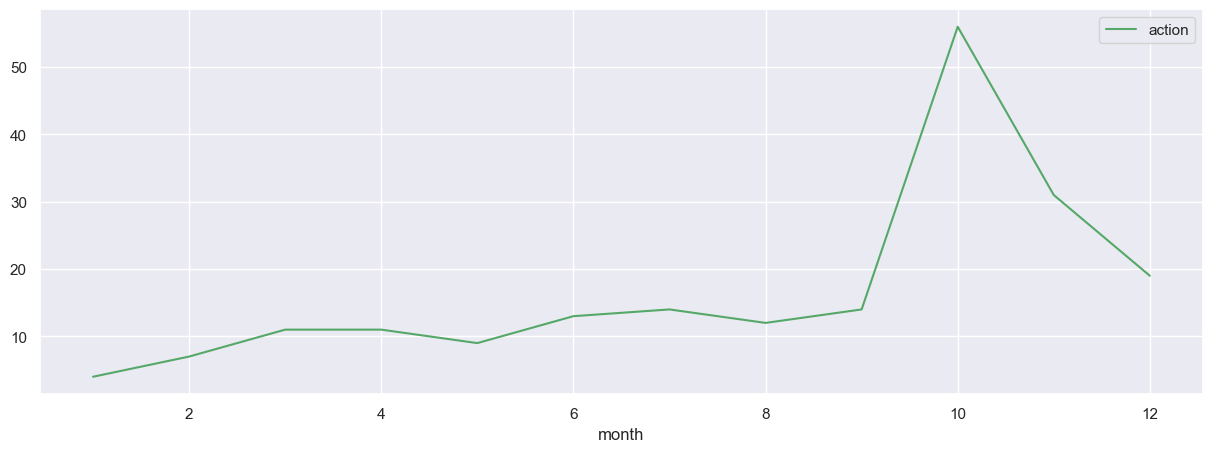

In [81]:
# Converting into date
temp = df4.copy()
temp['month'] = temp['date_time'].dt.month

# Number of unique users over the time
temp = temp[temp['action']=='purchase'].groupby('month').agg({'action': 'count'}).reset_index().sort_values(by='month')

# plot over the time
temp.set_index('month').plot(figsize=(15,5), color='g')
plt.show()

## 4.3. Multivariate Analysis

The main objective of this analysis is to evaluate the correlation between the variables. We only did multivariate analysis for numerical attributes, since we already did it for categorical data in the sections 1.7.4.

To analyze the correlation between numerical variables, we may use Pearson method. We cannot use this method to analyze categorical variables.

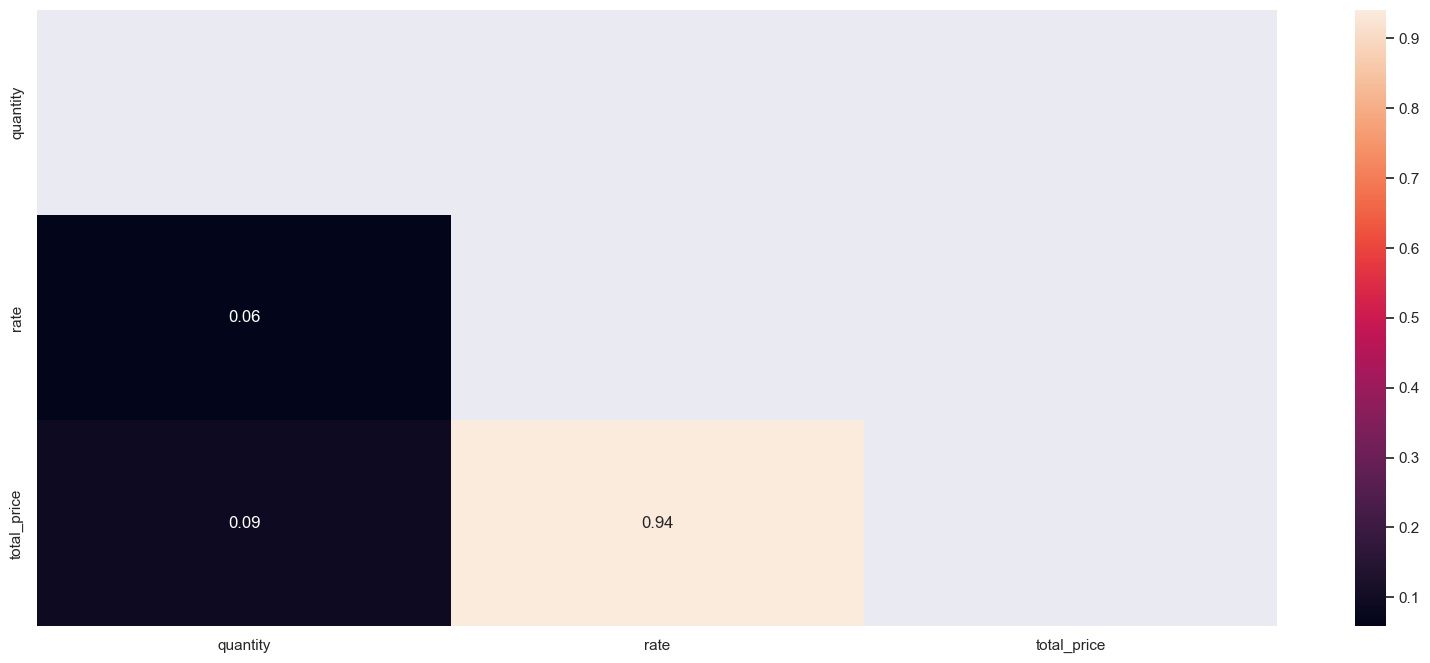

In [82]:
plt.figure(figsize = (20,8))

mask = np.zeros_like(num_attributes.corr(method="pearson"), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(num_attributes.corr(method="pearson"), mask = mask, annot=True);

- rate and total price are very correlated: 0.94.

Both of them have the same available count. Thus, we may choose any of them to be removed.

# 5. Data Pre-processing

In [83]:
df5 = df3.copy()

In [84]:
df5.head()

,user_id,session_id,date_time,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,speakers,first_app_open,0.00,0.00,0.00,2019,1,10,3,2
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,speakers,search,0.00,0.00,0.00,2019,1,10,3,2
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,jeans,search,0.00,0.00,0.00,2019,1,10,3,2
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,jeans,product_view,0.00,0.00,0.00,2019,1,10,3,2
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,jeans,read_reviews,0.00,0.00,0.00,2019,1,10,3,2


## 5.1. Recency, Frequency and Monetary score (RFM)

RFM features of customers illustrates these characteristics:

- The more recent they purchase, the more responsive they are to the promotions.
- The more frequent they purchase, the more engaged and satisfied they are.
- The more monetary value helps to differentiate high spenders vs low spenders.

To do the RFM analysis, we need to create 3 features from the data:

- Recency - [Latest date - Last invoice date] (Number of days since the last purchase date)
- Frequency - count of invoice numbers. (Total number of transactions made by a unique customer)
- Monetary - Sum of Total sales. (Total value of transacted sales by each customer)

In [85]:
def RFM_Features(df, customerID, invoiceDate, transID, sales):
    ''' Create the Recency, Frequency, and Monetary features from the data '''
    # Final date in the data + 1 to create latest date
    latest_date = df[invoiceDate].max() + timedelta(1)
    
    # RFM feature creation
    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days, 
                                          transID: lambda x: len(x), 
                                          sales: lambda x: sum(x)})
    
    # Converting invoiceDate to int since this contains number of days
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    
    # Renaming column names to Recency, Frequency and Monetary
    RFMScores.rename(columns={invoiceDate: 'Recency', 
                         transID: 'Frequency', 
                         sales: 'Monetary'}, inplace=True)
    
    return RFMScores.reset_index()

In [88]:
RFM = RFM_Features(df=df5[df5['action']=='purchase'], customerID= "user_id", invoiceDate = "date_time", transID= "session_id", sales="total_price")
print(RFM.shape)
RFM.head()

(122, 4)


,user_id,Recency,Frequency,Monetary
0,51448162784,194,1,1500.00
1,51462598385,7,2,550.00
2,51463622150,40,2,950.00
3,51465529647,10,2,15500.00
4,51468519074,286,1,2500.00


,Recency,Frequency,Monetary
count,122.00,122.00,122.00
mean,112.30,1.17,2504.34
std,91.99,0.40,2098.42
min,1.00,1.00,150.00
25%,41.00,1.00,1000.00
50%,72.00,1.00,2000.00
75%,164.00,1.00,3000.00
max,345.00,3.00,15500.00


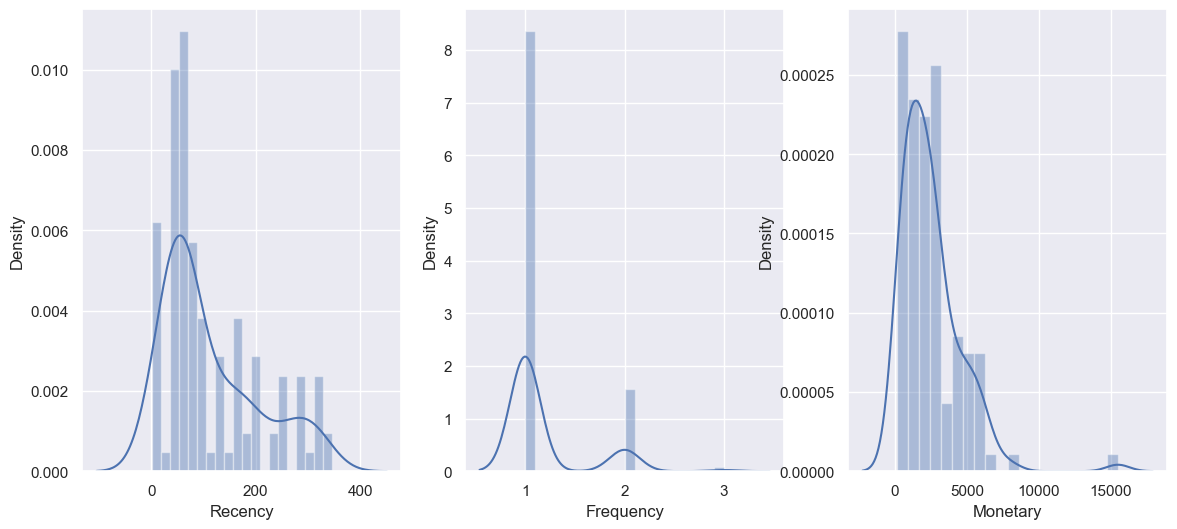

In [90]:
# Distribution of RFM features
display(RFM.drop('user_id',axis=1).describe())

# Distributions of Recency, Frequency, and Monetary features
fig, ax = plt.subplots(1,3, figsize=(14,6))
sns.distplot(RFM.Recency, bins=20, ax=ax[0])
sns.distplot(RFM['Frequency'], bins=20, ax=ax[1])
sns.distplot(RFM['Monetary'], bins=20, ax=ax[2])
plt.show()

To conduct RFM analysis, we need to rank the customers based on each RFM attribute separately.

Assume that we rank these customers from 1-4 using RFM values. (1-low score & 4-High score)

Steps to be followed for RFM ranking:

Sort the Recency column by most recent purchases at the top. For Frequency and Monetary features sort it by the most frequent and most valuable purchases at the top.
If you are using N-scale ranking to rank the customers then you have to divide the sorted values of the features into 1/N groups. Here, we are using 4-scale ranking hence we need to divide the values into 4 groups.
we can do both the sorting and grouping using pandas df.quantile method by providing the number of quantiles as a list.

**NOTE:** The value of N decides the number of different RFM rank groups you want to create. All possible combination of ranks from 1-N for all the three RFM features results in N^3 rank groups ranging from 111(lowest) to NNN(highest).

In our case N=4, hence we could have a maximum of 4^3 = 64 rank groups with scores from 111 to 444.

In [91]:
RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])

,Recency,Frequency,Monetary
0.25,41.00,1.00,1000.00
0.50,72.00,1.00,2000.00
0.75,164.00,1.00,3000.00


In [92]:
# Creating quantiles 
Quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
Quantiles = Quantiles.to_dict()
Quantiles

{'Recency': {0.25: 41.0, 0.5: 72.0, 0.75: 164.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 1000.0, 0.5: 2000.0, 0.75: 3000.0}}

In [93]:
# Creating RFM ranks
def RFMRanking(x, variable, quantile_dict):
    ''' Ranking the Recency, Frequency, and Monetary features based on quantile values '''
    
    # checking if the feature to rank is Recency
    if variable == 'Recency':
        if x <= quantile_dict[variable][0.25]:
            return 4
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 3
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 2
        else:
            return 1
    
    # checking if the feature to rank is Frequency and Monetary
    if variable in ('Frequency','Monetary'):
        if x <= quantile_dict[variable][0.25]:
            return 1
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 2
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 3
        else:
            return 4

In [94]:
RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))

In [95]:
print(RFM.shape)
RFM.head()

(122, 7)


,user_id,Recency,Frequency,Monetary,R,F,M
0,51448162784,194,1,1500.00,1,1,2
1,51462598385,7,2,550.00,4,4,1
2,51463622150,40,2,950.00,4,4,1
3,51465529647,10,2,15500.00,4,4,4
4,51468519074,286,1,2500.00,1,1,3


In [96]:
RFM['Group'] = RFM['R'].apply(str) + RFM['F'].apply(str) + RFM['M'].apply(str)
RFM.head()

,user_id,Recency,Frequency,Monetary,R,F,M,Group
0,51448162784,194,1,1500.00,1,1,2,112
1,51462598385,7,2,550.00,4,4,1,441
2,51463622150,40,2,950.00,4,4,1,441
3,51465529647,10,2,15500.00,4,4,4,444
4,51468519074,286,1,2500.00,1,1,3,113


In [97]:
RFM["Score"] = RFM[['R', 'F', 'M']].sum(axis=1)
RFM.head()

,user_id,Recency,Frequency,Monetary,R,F,M,Group,Score
0,51448162784,194,1,1500.00,1,1,2,112,4
1,51462598385,7,2,550.00,4,4,1,441,9
2,51463622150,40,2,950.00,4,4,1,441,9
3,51465529647,10,2,15500.00,4,4,4,444,12
4,51468519074,286,1,2500.00,1,1,3,113,5


In [98]:
# Loyalty levels
loyalty = ['Bronze', 'Silver', 'Gold', 'Platinum']
RFM['Loyalty_Level'] = pd.qcut(RFM['Score'], q=4, labels= loyalty)
RFM.head()

,user_id,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
0,51448162784,194,1,1500.00,1,1,2,112,4,Bronze
1,51462598385,7,2,550.00,4,4,1,441,9,Platinum
2,51463622150,40,2,950.00,4,4,1,441,9,Platinum
3,51465529647,10,2,15500.00,4,4,4,444,12,Platinum
4,51468519074,286,1,2500.00,1,1,3,113,5,Bronze


In [99]:
behaviour = RFM.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'Score']].mean()
behaviour

,Recency,Frequency,Monetary,Score
Loyalty_Level,,,,
Bronze,193.14,1.00,1357.14,4.24
Silver,97.07,1.00,2211.67,6.00
Gold,62.60,1.04,3105.20,7.32
Platinum,44.44,1.80,4182.00,10.12


There are two broad ways in which the RFM features can be utilized:
* **Preferrential Treatments:** RFM features and loyalty tags will be available only for existing users. So, whenever old users shows interest in any product, based on their loyalty tags we can target them with personalized discounts etc.


* **High value path:** We can analyze the behaviour exhibited by the old users and create multiple behaviour paths that leads to increased purchase. This learning can then be used to nudge new users to follow such paths and hence increase the probability of purchase.

### 5.1.1. Adding the RFM Features to the Base Dataset

In [100]:
data_with_RFM = pd.merge(df5, RFM, on='user_id', how='left')
print(data_with_RFM.shape)
data_with_RFM.head()

(2032, 22)


,user_id,session_id,date_time,sub_category,action,quantity,rate,total_price,year,month,...,week_of_year,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,speakers,first_app_open,0.00,0.00,0.00,2019,1,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,speakers,search,0.00,0.00,0.00,2019,1,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,jeans,search,0.00,0.00,0.00,2019,1,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,jeans,product_view,0.00,0.00,0.00,2019,1,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,jeans,read_reviews,0.00,0.00,0.00,2019,1,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
data_with_RFM.isna().sum()

user_id             0
session_id          0
date_time           0
sub_category        0
action              0
quantity            0
rate                0
total_price         0
year                0
month               0
day                 0
day_of_week         0
week_of_year        0
Recency          1062
Frequency        1062
Monetary         1062
R                1062
F                1062
M                1062
Group            1062
Score            1062
Loyalty_Level    1062
dtype: int64

As we are only inrested in users who purchase, thus we may remove missing values (those who did not purchase).